<a href="https://www.kaggle.com/code/elinteerie/nigeria-food-ai-model-with-kaggle?scriptVersionId=102659929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nigeria-food-ai-dataset/1HZhs21IE2oNn_V7PF_atNDizdhV8z-vP


**Importing Dependences** and helper functions

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

#Importing my Beautiful functions for flexibility
!wget https://raw.githubusercontent.com/elinteerie/helper/main/helper_functions.py

from helper_functions import *

--2022-08-06 11:48:15--  https://raw.githubusercontent.com/elinteerie/helper/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14934 (15K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.58K  --.-KB/s    in 0s      

2022-08-06 11:48:15 (46.3 MB/s) - ‘helper_functions.py’ saved [14934/14934]



In [3]:
##Unzipping the Dataset using a Helper Function I wrote

In [4]:
unzip_data('/kaggle/input/nigeria-food-ai-dataset/1HZhs21IE2oNn_V7PF_atNDizdhV8z-vP')

Setting up directory variable

In [5]:
dir = '/nigfoodai'

In [6]:
train_dir = 'nigfoodai' # Will be splitted for test or Validation

In [7]:
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 labels ='inferred',
                                                                 label_mode="int",
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.15,
                                                                 subset='training',
                                                                 seed =42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                labels ='inferred',
                                                                 label_mode="int",
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.15,
                                                                 subset='validation',
                                                                seed =42)


Found 3449 files belonging to 14 classes.
Using 2932 files for training.


2022-08-06 11:48:29.662122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 11:48:29.773584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 11:48:29.774423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 11:48:29.777056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3449 files belonging to 14 classes.
Using 517 files for validation.


2022-08-06 11:48:32.845665: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


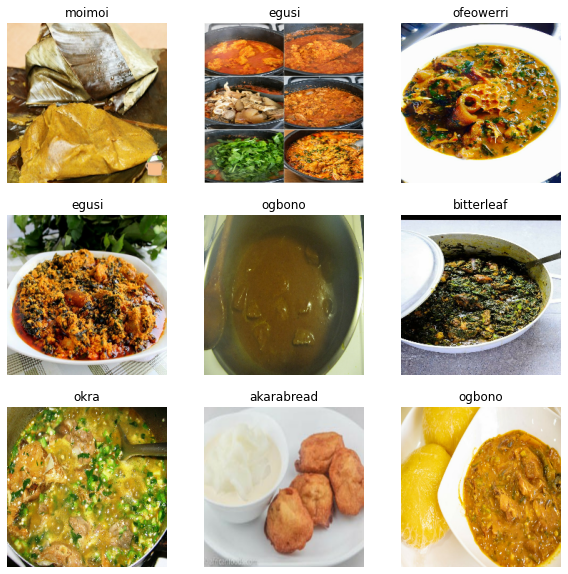

In [8]:
ngclass_names = train_data.class_names

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(ngclass_names[labels[i].numpy()])
    plt.axis("off")

Data Augumentation

In [9]:
###Setting Up Data Argumentation
from tensorflow.keras import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50 but i am using EfficientNetX
], name="data_augmentation")

Adding Autotune for Performance efficiency

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

Setting Up Baseline Model For Feature Extraction

In [12]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(14, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

71696384/71686520 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1792)              0         
_________________________________________________________________
output_layer (Dense)         (None, 14)                25102     
Total params: 17,698,925
Trainable params: 25,102
Non-trainable params: 17,673,823
_________________________________________________________________


Compiling the Model and Fitting

In [14]:
# Compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_model = model.fit(train_data,epochs=3, # fit for 3 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[create_tensorboard_callback(dir_name = 'TensorBoard', experiment_name ='model_1b3'),
                                                      create_model_checkpoint('Checkpoint')])

2022-08-06 11:48:41.409273: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-06 11:48:41.409312: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-06 11:48:41.411349: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-06 11:48:41.604327: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Saving TensorBoard log files to: TensorBoard/model_1b3/20220806-114841
Epoch 1/3


2022-08-06 11:48:41.604542: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-08-06 11:48:53.684788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/92 [..............................] - ETA: 26:32 - loss: 2.8055 - accuracy: 0.0625

2022-08-06 11:48:59.747936: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-06 11:48:59.747994: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 1:40 - loss: 2.7338 - accuracy: 0.0938 

2022-08-06 11:49:00.561614: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-06 11:49:00.564740: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-06 11:49:00.714033: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3638 callback api events and 3202 activity events. 
2022-08-06 11:49:00.764096: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-06 11:49:00.848904: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: TensorBoard/model_1b3/20220806-114841/train/plugins/profile/2022_08_06_11_49_00

2022-08-06 11:49:00.902969: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to TensorBoard/model_1b3/20220806-114841/train/plugins/profile/2022_08_06_11_49_00/91f1e903ec68.trace.json.gz
2022-08-06 11:49:00.986814: I tensorflow/core/profiler

92/92 [==============================] - 52s 375ms/step - loss: 1.6209 - accuracy: 0.5153 - val_loss: 1.1212 - val_accuracy: 0.6673

Epoch 00001: saving model to Checkpoint/20220806-114841.ckpt


2022-08-06 11:49:58.847463: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
92/92 [==============================] - 18s 190ms/step - loss: 1.0794 - accuracy: 0.6811 - val_loss: 0.9315 - val_accuracy: 0.7157

Epoch 00002: saving model to Checkpoint/20220806-114841.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/3
92/92 [==============================] - 17s 186ms/step - loss: 0.9174 - accuracy: 0.7217 - val_loss: 0.8380 - val_accuracy: 0.7679

Epoch 00003: saving model to Checkpoint/20220806-114841.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
model_results = model.evaluate(test_data)

17/17 [==============================] - 2s 89ms/step - loss: 0.8380 - accuracy: 0.7679


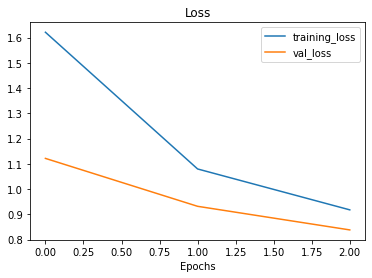

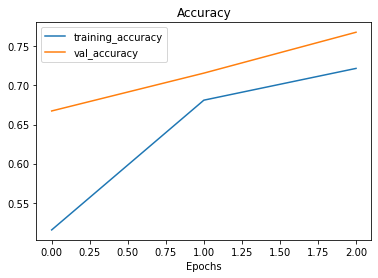

In [16]:
plot_loss_curves(history_model)

In [17]:
##Fine Tuning

In [18]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-30]:
  layer.trainable = False


In [19]:
# Recompile model with lower learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_2_model = model.fit(train_data, epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_model.epoch[-1]) # start from previous last epoch

Epoch 3/10
92/92 [==============================] - 34s 226ms/step - loss: 0.7374 - accuracy: 0.7602 - val_loss: 0.6505 - val_accuracy: 0.7930
Epoch 4/10
92/92 [==============================] - 18s 192ms/step - loss: 0.5449 - accuracy: 0.8220 - val_loss: 0.5856 - val_accuracy: 0.8104
Epoch 5/10
92/92 [==============================] - 16s 175ms/step - loss: 0.4145 - accuracy: 0.8680 - val_loss: 0.5780 - val_accuracy: 0.8143
Epoch 6/10
92/92 [==============================] - 16s 175ms/step - loss: 0.3168 - accuracy: 0.8973 - val_loss: 0.5808 - val_accuracy: 0.8395
Epoch 7/10
92/92 [==============================] - 16s 174ms/step - loss: 0.2657 - accuracy: 0.9151 - val_loss: 0.5702 - val_accuracy: 0.8453
Epoch 8/10
92/92 [==============================] - 15s 167ms/step - loss: 0.2175 - accuracy: 0.9263 - val_loss: 0.5852 - val_accuracy: 0.8530
Epoch 9/10
92/92 [==============================] - 15s 167ms/step - loss: 0.1628 - accuracy: 0.9465 - val_loss: 0.5419 - val_accuracy: 0.8588

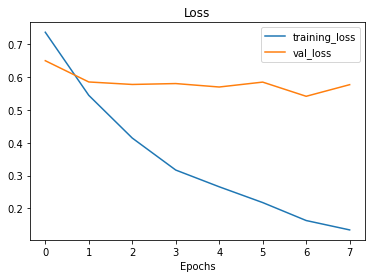

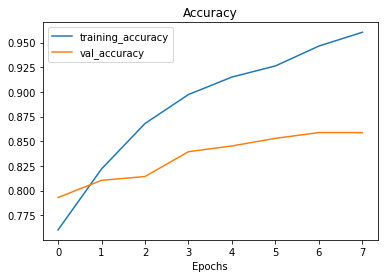

In [21]:
plot_loss_curves(history_2_model)

In [22]:
model_tuned_results = model.evaluate(test_data)

17/17 [==============================] - 2s 89ms/step - loss: 0.5774 - accuracy: 0.8588


More can be done to improve result but for now it just a welcome jupyter notebook for y'all